# Author

Luiz Gustavo Mugnaini Anselmo

# Using `pytorch` to solve the MNIST dataset classification problem

In this notebook I implement two method for classiying the classic [MNIST](https://en.wikipedia.org/wiki/MNIST_database), one with a fully connected neural network and another with a convolutional neural network. In both cases we analyze the effect of different optimizers and loss functions.

# MNIST setup

## Imports

Here we list all imports that will be used throughout this notebook:

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import (Dataset, DataLoader)
import torchvision
from torchvision.transforms import ToTensor

import itertools

import matplotlib.pyplot as plt
import numpy as np

Setting configurations for working with `pytorch`:

In [3]:
torch.manual_seed(293819)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE} device")

Using cpu device


## Data fetching

For the data fetching, we first set a constant determining the batch size used by the data loader:

In [ ]:
BATCH_SIZE = 64

In [ ]:
train_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
)

100%|██████████| 9912422/9912422 [00:00<00:00, 42211072.30it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 26664251.34it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 31242591.95it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14836860.41it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

test_loader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
)

## Getting to know the dataset

Lets first get the image resolution of the MNIST samples:

In [ ]:
sample0_np = train_data[0][0].numpy().squeeze()
IMG_HEIGHT, IMG_WIDTH = sample0_np.shape
print(f"Image height: {IMG_HEIGHT}\nImage width: {IMG_WIDTH}")

Image height: 28
Image width: 28


Lets plot some samples from `train_data`:

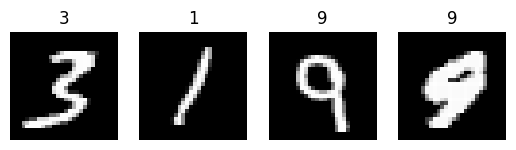

In [ ]:
figure = plt.figure()
n_samples = 4
for i in range(1, n_samples + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[int(sample_idx)]
    figure.add_subplot(1, n_samples, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Parameters

Here we list some of the parameters that will be combined inside of the training and testing stage for analysis:

In [ ]:
LEARNING_RATE = 0.001

LOSSES = [
    nn.CrossEntropyLoss(),
    nn.NLLLoss(),
]

OPTIMIZERS = [
    torch.optim.SGD,
    torch.optim.Adam,
]

## Model testing

The following function deals with the verification of a trained model against the `test_data`:

In [ ]:
def test(model: nn.Module, loss_fn, loader: DataLoader=test_loader):
    print("=> Running the test...")
    model.eval()  # Set the model to evaluation mode
    test_loss, n_correct = 0.0, 0
    with torch.no_grad():  # The autograd should be disabled in testing
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

            pred = model(X_batch)
            test_loss += loss_fn(pred, y_batch).item()
            n_correct += (pred.argmax(1) == y_batch).type(torch.float).sum().item()

    test_loss /= len(loader)
    n_correct /= len(loader.dataset)
    print(f"Accuracy: {100 * n_correct}\nAvg. loss: {test_loss}")

We now create a function to combine the above defined hyperparameters in order to test their performance:

In [ ]:
def test_hyperparams(
    model,
    train_fn,
    lr=[LEARNING_RATE],
    losses=LOSSES,
    optimizers=OPTIMIZERS,
):
    print(f"{'Hyperparameter test':=^80}")
    print(f"=> Model: {model}")
    params = itertools.product(lr, losses, optimizers)
    for idx, (lr, loss_fn, op) in enumerate(params):
        print(
            "\n\n=> Hyperparameters {}:\n"
            f"\tlearning rate: {lr}\n"
            f"\tloss function: {loss_fn}\n"
            f"\toptimizer: {op}\n"
        )
        train_fn(model, train_loader, loss_fn, op)
        print()
        test(model, loss_fn)

# Fully connected neural network

## Defining the model

In [ ]:
class FullyConnNet(nn.Module):
    def __init__(self):
        super(FullyConnNet, self).__init__()
        self.flatten = nn.Flatten()
        self.lin_relu_seq = nn.Sequential(
            nn.Linear(IMG_HEIGHT * IMG_WIDTH, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, X):
        X = self.flatten(X)
        X = self.lin_relu_seq(X)
        return F.log_softmax(X, dim=1)

def fc_train(
    fc_model,
    loader,
    loss_fn,
    optimizer,
    lr=LEARNING_RATE,
    n_epochs=5,
    verbose=True
):
    print("=> Training the model...")
    optimizer = optimizer(fc_model.parameters(), lr=lr)
    fc_model.train()  # Set the model to training mode
    for epoch in range(n_epochs):
        loss, n_correct = 0.0, 0
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

            pred = fc_model(X_batch)
            loss = loss_fn(pred, y_batch)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Total correct predictions
            n_correct += (pred.argmax(1) == y_batch).type(torch.float).sum().item()

        acc = 100.0 * (n_correct / len(loader.dataset))
        if verbose:
            print(f"[Epoch {epoch}] Accuracy: {acc:0.3f}\tLoss: {loss:0.3f}")

## Model evaluation

In [ ]:
fc_model = FullyConnNet().to(DEVICE)
test_hyperparams(fc_model, fc_train)

==============================Hyperparameter test===============================
=> Model: FullyConnNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin_relu_seq): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)


=> Hyperparameters:
	learning rate: 0.001
	loss function: CrossEntropyLoss()
	optimizer: <class 'torch.optim.sgd.SGD'>

=> Training the model...
[Epoch 0] Accuracy: 44.138	Loss: 2.094
[Epoch 1] Accuracy: 70.975	Loss: 1.696
[Epoch 2] Accuracy: 75.385	Loss: 1.569
[Epoch 3] Accuracy: 78.775	Loss: 1.189
[Epoch 4] Accuracy: 81.058	Loss: 1.107
=> Running the test...
Accuracy: 83.21
Avg. loss: 0.9451547599142525


=> Hyperparameters:
	learning rate: 0.001
	loss function: CrossEntropyLoss()
	optimizer: <class 'torch.optim.adam.Adam'>

=> Training the model...
[Epoch 0] Accuracy: 93.778	Loss: 0.109
[Epoch 1] Accuracy: 97.210	Loss: 0.067
[Epoch 2] Accuracy: 98.138	Loss: 0.0

# Convolutional neural network

## Defining the model

In [ ]:
class CNN(nn.Module):
    def __init__(self, kernel_size=5, mp_kernel_size=2):
        super(CNN, self).__init__()
        self.conv_seq = nn.Sequential(
            # Conv 1
            nn.Conv2d(1, 32, kernel_size=kernel_size),
            nn.ReLU(),
            # Conv 2
            nn.Conv2d(32, 32, kernel_size=kernel_size),
            nn.ReLU(),
            nn.MaxPool2d(mp_kernel_size),
            nn.Dropout(),
            # Conv 3
            nn.Conv2d(32, 64, kernel_size=kernel_size),
            nn.ReLU(),
            nn.MaxPool2d(mp_kernel_size),
            nn.Dropout(),
        )
        self.fully_conn_seq = nn.Sequential(
            # Fully connected 1
            nn.Linear(3 * 3 * 64, 256),
            nn.ReLU(),
            nn.Dropout(),
            # Fully connected 2
            nn.Linear(256, 10),
        )

    def forward(self, X):
        X = self.conv_seq(X)
        X = X.view(-1, 3 * 3 * 64)
        X = self.fully_conn_seq(X)
        return F.log_softmax(X, dim=1)

def cnn_train(
    cnn_model,
    loader,
    loss_fn,
    optimizer,
    lr=LEARNING_RATE,
    n_epochs=5,
    verbose=True
):
    print("=> Training the model...")
    optimizer = optimizer(cnn_model.parameters(), lr=lr)
    cnn_model.train()  # Set the model to training mode
    for epoch in range(n_epochs):
        loss, n_correct = 0.0, 0
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

            pred = cnn_model(X_batch)

            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()  # Reset optimizer gradients

            # Total correct predictions
            n_correct += (pred.argmax(1) == y_batch).type(torch.float).sum().item()

        acc = 100.0 * (n_correct / len(loader.dataset))
        if verbose:
            print(f"[Epoch {epoch}] Accuracy: {acc:0.3f}\tLoss: {loss:0.3f}")

## Model evaluation

In [ ]:
cnn_model = CNN().to(DEVICE)
test_hyperparams(cnn_model, cnn_train)

==============================Hyperparameter test===============================
=> Model: CNN(
  (conv_seq): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.5, inplace=False)
  )
  (fully_conn_seq): Sequential(
    (0): Linear(in_features=576, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)


=> Hyperparameters:
	learning rate: 0.001
	loss function: CrossEntropyLoss()
	optimizer: <class 'torch.optim.sgd.SGD'>

=> Training the model...
[Epoch 0] Accuracy: 10.112	Loss: 2.305
[E

# Bibliography

* [Pytorch quickstart tutorial](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html).
* [Pytorch documentation](https://pytorch.org/docs/stable/index.html).
* [Neuromatch Academy: Deep Learning](https://deeplearning.neuromatch.io/tutorials/intro.html).
